In [2]:
import torch
import logging
import pickle
import glob
import random
import numpy as np
from torch.utils.data import Dataset
from torch.nn import functional as F
from typing import Union
from functools import partial

In [15]:
def alpha_bar_cosine(time_step, s = 0.0, e = 1.0, tau=1.0, clip_min = 1e-9, **kwargs):
    v_start = np.cos((s + 0.008) / 1.008 * np.pi / 2) ** (2*tau)
    v_end = np.cos((e + 0.008) / 1.008 * np.pi / 2) ** (2*tau)
    v = np.cos((time_step * (e-s)+s + 0.008) / 1.008 * np.pi / 2) ** (2*tau)
    return np.clip((v_end - v) / (v_end - v_start), clip_min, 1)
    # return np.cos((time_step + 0.008) / 1.008 * np.pi / 2) ** 2
    
def alpha_bar_log(time_step, tau = 2.5, clip_min = 1e-9, **kwargs):
    # ! Hard code to shift the schedule 
    # delta = 10**-tau
    # return np.clip(np.log(time_step+delta)/np.log(delta), clip_min, 1)
    
    delta = 10**-tau
    v_start = np.log(delta)
    v_end = np.log(1+delta)
    v = np.log(time_step+delta)
    return np.clip((v_end - v) / (v_end - v_start), clip_min, 1)

def alpha_bar_linear(time_step, clip_min = 1e-9, **kwargs):
    return np.clip((1-time_step), clip_min, 1.)

def alpha_bar_sigmoid(time_step, s = -3, e = 3, tau=1, clip_min = 1e-9, **kwargs):
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    v_start = sigmoid(s/tau)
    v_end = sigmoid(e/tau)
    v = sigmoid((time_step*(e-s)+s)/tau)
    return np.clip((v_end - v) / (v_end - v_start), clip_min, 1)


def get_beta_schedule(variant, num_diffusion_timesteps, clip_min = 1e-9, max_beta=0.999, scale = 1.0, **kwargs):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function, which defines the cumulative product of
    (1-beta) over time from t = [0,1].

    Contains a function alpha_bar that takes an argument t and transforms it to the cumulative product of (1-beta) up
    to that part of the diffusion process.
    """

    if variant == 'cosine':
        alpha_bar = partial(alpha_bar_cosine, clip_min = clip_min, **kwargs)
    elif variant == 'log':
        alpha_bar = partial(alpha_bar_log, clip_min = clip_min, **kwargs)
    elif variant == 'sigmoid':
        alpha_bar = partial(alpha_bar_sigmoid, clip_min = clip_min, **kwargs)
    elif variant == 'linear':
        # scale = 0.02
        alpha_bar = partial(alpha_bar_linear, clip_min = clip_min, **kwargs)
    elif variant == 'linear-cifar':
        beta_start = 1e-4
        beta_end = 0.02
        betas = torch.linspace(beta_start, beta_end, num_diffusion_timesteps+1)
        return betas.float()
    betas = [(1 - alpha_bar(time_step = 0)*scale)]
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(time_step = t2) / alpha_bar(time_step = t1), max_beta)*scale)
    # betas[0] = betas[0]*(1-scale)
    return torch.tensor(betas, dtype=torch.float32)


In [26]:
betas = get_beta_schedule('linear-cifar', 1000, scale=1)
betas = betas[1:]
betas_sqrt = betas.sqrt()
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, 0)

etas = torch.ones_like(alphas).float()
for t in range(1, 1000):
    partial_alphas = alphas[1:(t+1)]
    # [a_{t}, a_{t} * a_{t-1}, a_{t} * a_{t-1} * a_{t-2}, ..., (a_{t} * ... * a_{2})] 
    reversed_alphas_bar = torch.cumprod(torch.flip(partial_alphas, [0]), dim = 0)
    sqrt_reversed_alphas_bar = torch.sqrt(reversed_alphas_bar)
    etas[t] = sqrt_reversed_alphas_bar.sum() + 1.
etas_prev = torch.zeros_like(etas)
etas_prev[1:] = etas[:-1].clone().float()
etat_over_etaT = etas / etas[-1]

eps_coeff = 1 / alphas ** 0.5

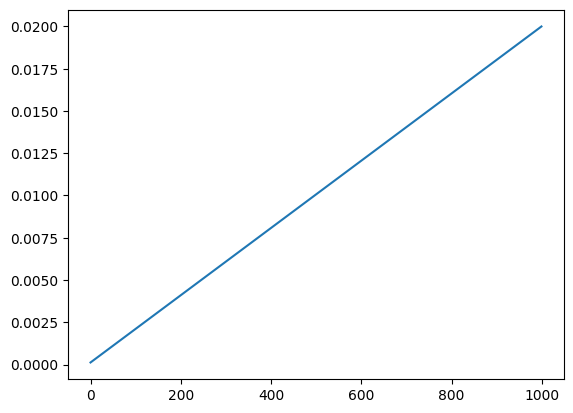

In [22]:
import  matplotlib.pyplot as plt
plt.plot(np.arange(betas.shape[0]), betas) 

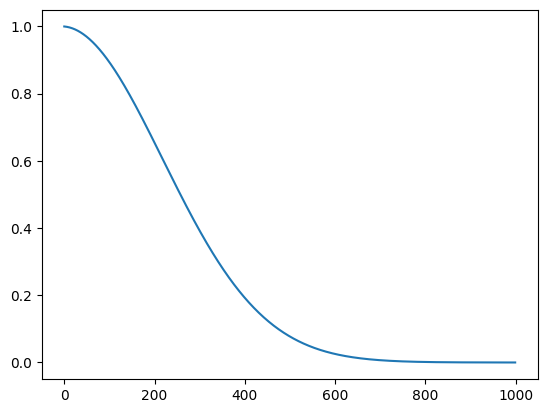

In [23]:
plt.plot(np.arange(betas.shape[0]), alphas_cumprod) 

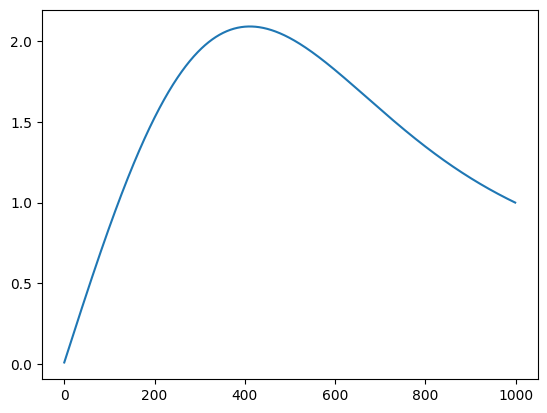

In [24]:
plt.plot(np.arange(betas.shape[0]), etat_over_etaT)

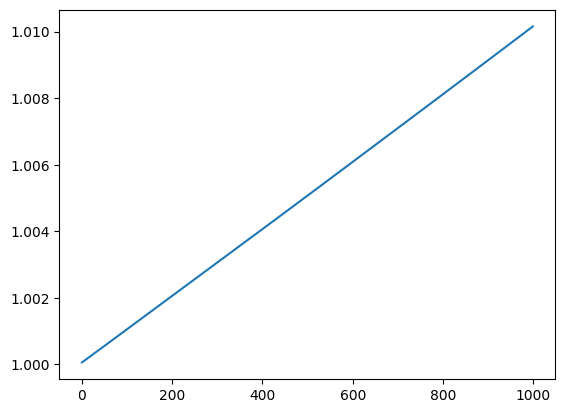

In [27]:
plt.plot(np.arange(betas.shape[0]), eps_coeff)

In [ ]:
plt.plot

In [25]:
print(etas[-1])

tensor(114.7979)


In [3]:
betas = get_beta_schedule(variant = 'cosine', num_diffusion_timesteps = 100)

In [4]:
len(betas)

101

In [5]:
class DDPM_Sampler(torch.nn.Module):
    def __init__(
        self, steps=100, schedule='cosine',
        clamp_val: float = 5.0, **kwargs
    ):
        super().__init__()
        self.num_steps = steps
        self.schedule = schedule
        self.clamp_val = clamp_val
        
        betas = get_beta_schedule(variant = self.schedule, num_diffusion_timesteps = self.num_steps, **kwargs)
        betas_sqrt = betas.sqrt()
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, 0)
        
        self.register_buffer('betas', betas[1:])
        self.register_buffer('betas_sqrt', betas_sqrt[1:])
        self.register_buffer('alphas', alphas[1:])
        self.register_buffer('alphas_cumprod', alphas_cumprod[1:])
        
    @torch.no_grad()
    def add_noise(
        self, 
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.IntTensor
    ):

        assert (timesteps < self.num_steps).all()
        
        # Make sure alphas_cumprod and timestep have same device and dtype as original_samples
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        while len(timesteps.shape) < len(original_samples.shape):
            timesteps = timesteps.unsqueeze(-1)
            
        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        
        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5

        noised_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        
        return noised_samples
    
    def get_noise(
        self,
        x_0: torch.FloatTensor,
        x_t: torch.FloatTensor,
        timesteps: Union[int, torch.IntTensor],
        gt_noise: torch.FloatTensor = None
    ):
        assert (timesteps < self.num_steps).all()
        
        # Make sure alphas_cumprod and timestep have same device and dtype as original_samples
        alphas_cumprod = self.alphas_cumprod.to(device=x_0.device, dtype=x_0.dtype)
        timesteps = timesteps.to(x_0.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        # sqrt_alpha_prod = sqrt_alpha_prod.flatten()

        while len(sqrt_alpha_prod.shape) < len(x_0.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        # sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()

        while len(sqrt_one_minus_alpha_prod.shape) < len(x_0.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        # noised_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        noise = (x_t - sqrt_alpha_prod * x_0) / sqrt_one_minus_alpha_prod
        
        if gt_noise is not None:
            scaled_error = torch.nn.functional.mse_loss(
                x_t - sqrt_alpha_prod * x_0, gt_noise*sqrt_one_minus_alpha_prod, reduction='mean')
        else:
            scaled_error = None
        
        return noise, scaled_error

In [10]:
sampler = DDPM_Sampler()

In [26]:
B = 2
original_sample = torch.randn((B,1,80,5))
noise = torch.randn((B,1,80,5))
steps = torch.randint(
                0, sampler.num_steps, (B,)
            ).long().unsqueeze(-1).view(B, 1, 1, 1)
sampler.add_noise(original_sample, noise, steps)

tensor([[[[ 2.4268e-02,  4.6908e-01, -1.5573e+00, -3.3723e-01, -1.3192e+00],
          [-1.0491e+00,  3.5433e-01,  7.5800e-01,  3.6562e-01,  2.2802e-01],
          [ 9.8744e-01,  1.7230e-01,  1.3005e+00,  1.4031e-01, -8.8281e-01],
          [ 1.8234e+00, -1.6043e+00,  1.0588e+00, -6.8147e-01,  5.3653e-01],
          [-4.5130e-02,  1.6614e+00,  7.4311e-01, -1.3476e+00, -9.1833e-01],
          [ 8.1996e-02,  6.2891e-01, -4.6691e-01, -5.1358e-01, -4.9320e-01],
          [ 6.2347e-02, -3.5867e-01,  5.5553e-01,  7.5251e-01,  1.4884e+00],
          [-1.2993e+00, -1.5385e+00, -3.3983e-01, -2.6056e-01,  1.1774e+00],
          [-1.3013e+00,  5.2288e-01, -1.0918e+00, -4.1742e-01,  2.4014e+00],
          [-5.0699e-01,  5.2543e-01, -1.9914e-01,  3.9219e-01,  9.6592e-01],
          [ 1.1637e+00,  1.8975e-01, -1.0964e+00,  1.3831e+00, -6.1608e-01],
          [-3.1640e-01, -3.0816e-01,  7.0477e-02,  3.2646e-01, -7.6254e-01],
          [-1.4580e-01, -4.6664e-01, -1.2849e+00, -6.6689e-01, -1.2525e+00],

In [23]:
(steps < 100).all()

tensor(True)

In [14]:
class DDPM_Sampler_MultiModal(torch.nn.Module):
    def __init__(
        self, steps=100, schedule='cosine', 
        prior_means=[0,1,2,3], prior_std=1,
        clamp_val: float = 5.0, **kwargs
    ):
        super().__init__()
        self.num_steps = steps
        self.schedule = schedule
        self.clamp_val = clamp_val
        self.prior_means = torch.tensor(prior_means).to(torch.float64).cuda() # [num_of_labels,]
        self.prior_std = torch.tensor(prior_std).to(torch.float64).cuda() # [,]
        
        betas = get_beta_schedule(variant = self.schedule, num_diffusion_timesteps = self.num_steps, **kwargs)
        betas_sqrt = betas.sqrt()
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, 0)
        
        self.etas = torch.ones_like(alphas).to(alphas.device)
        for t in range(1, self.num_steps):
            partial_alphas = alphas[1:(t+1)]
            # [a_{t}, a_{t} * a_{t-1}, a_{t} * a_{t-1} * a_{t-2}, ..., (a_{t} * ... * a_{2})] 
            reversed_alphas_bar = torch.cumprod(torch.flip(partial_alphas, [0]), dim = 0)
            sqrt_reversed_alphas_bar = torch.sqrt(reversed_alphas_bar)
            self.etas[t] = sqrt_reversed_alphas_bar.sum() + 1 

        self.register_buffer('betas', betas[1:])
        self.register_buffer('betas_sqrt', betas_sqrt[1:])
        self.register_buffer('alphas', alphas[1:])
        self.register_buffer('alphas_cumprod', alphas_cumprod[1:])

        
    @torch.no_grad()
    def add_noise(
        self, 
        labels,  # B,
        original_samples: torch.FloatTensor, 
        noise: torch.FloatTensor,
        timesteps: torch.IntTensor
    ):

        assert (timesteps < self.num_steps).all()
        
        # Make sure alphas_cumprod and timestep have same device and dtype as original_samples
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)
        prior_means = self.prior_means.to(device=original_samples.device, dtype=original_samples.dtype)
        etas = self.etas.to(device=original_samples.device, dtype=original_samples.dtype)
        labels = labels.to(device=original_samples.device, dtype=torch.int64)
        means = prior_means[labels].to(device=original_samples.device, dtype=original_samples.dtype)
        eta_T = etas[self.num_steps - 1].to(device=original_samples.device, dtype=original_samples.dtype)
        # eta_ts = self._extract(self.etas, t, x_0).reshape([-1])
        eta_ts = etas[timesteps.reshape((-1))]
        # mean_terms = (eta_ts * means / eta_T).reshape([-1] + [1] * (len(x_0.shape) - 1))
        # mean_terms = mean_terms.tile([1] + list(x_0.shape[1:]))
        # mean_terms = mean_terms.to(x_0.dtype)
        mean_terms = (eta_ts * means / eta_T).reshape((-1,1,1,1))
        mean_terms = mean_terms.tile([1] + list(original_samples.shape[1:]))
        mean_terms = mean_terms.to(device=original_samples.device, dtype=original_samples.dtype)


        while len(timesteps.shape) < len(original_samples.shape):
            timesteps = timesteps.unsqueeze(-1)
            
        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.to(device=original_samples.device, dtype=original_samples.dtype)
        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.to(device=original_samples.device, dtype=original_samples.dtype)
        noise = noise.to(device=original_samples.device, dtype=original_samples.dtype)

        prior_std = self.prior_std.to(device=original_samples.device, dtype=original_samples.dtype)

        noised_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * prior_std * noise + mean_terms
        
        return noised_samples
    
    def get_noise(
        self,
        x_0: torch.FloatTensor,
        x_t: torch.FloatTensor,
        timesteps: Union[int, torch.IntTensor],
        gt_noise: torch.FloatTensor = None
    ):
        assert (timesteps < self.num_steps).all()
        
        # Make sure alphas_cumprod and timestep have same device and dtype as original_samples
        alphas_cumprod = self.alphas_cumprod.to(device=x_0.device, dtype=x_0.dtype)
        timesteps = timesteps.to(x_0.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        # sqrt_alpha_prod = sqrt_alpha_prod.flatten()

        while len(sqrt_alpha_prod.shape) < len(x_0.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        # sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()

        while len(sqrt_one_minus_alpha_prod.shape) < len(x_0.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        # noised_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        noise = (x_t - sqrt_alpha_prod * x_0) / sqrt_one_minus_alpha_prod
        
        if gt_noise is not None:
            scaled_error = torch.nn.functional.mse_loss(
                x_t - sqrt_alpha_prod * x_0, gt_noise*sqrt_one_minus_alpha_prod, reduction='mean')
        else:
            scaled_error = None
        
        return noise, scaled_error
    
    def set_timesteps(
        self,
        num_inference_steps = None,
        device = None):

        timesteps = (
            np.linspace(0, self.num_steps - 1, num_inference_steps)
            .round()[::-1]
            .copy()
            .astype(np.int64)
        )

        self.timesteps = torch.from_numpy(timesteps).to(device)
    
    def step(
        self,
        model_output: torch.FloatTensor,
        timesteps: Union[int, torch.IntTensor],
        sample: torch.FloatTensor,
        prediction_type: str = "sample"
    ):
        """
        Predict the sample from the previous timestep by reversing the SDE. This function propagates the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.FloatTensor`):
                The direct output from learned diffusion model.
            timestep (`float`):
                The current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                A current instance of a sample created by the diffusion process.
        """
        if not isinstance(timesteps, int):
            while len(timesteps.shape) < len(model_output.shape):
                timesteps = timesteps.unsqueeze(-1)
        # Compute predicted previous sample µ_t-1
        pred_prev_sample_mean = self.q_mean(model_output, timesteps, sample, prediction_type=prediction_type)
        # 6. Add noise
        device = model_output.device
        variance_noise = torch.randn(model_output.shape, device=device, dtype=model_output.dtype)
        
        variance = (self.q_variance(timesteps)**0.5) * variance_noise

        pred_prev_sample = pred_prev_sample_mean + variance

        return pred_prev_sample
    
    def q_mean(self,
        model_output: torch.FloatTensor,
        timesteps: Union[int, torch.IntTensor],
        sample: torch.FloatTensor,
        prediction_type: str = "sample",
    ):
        """
        Predict the sample from the previous timestep by reversing the SDE. This function propagates the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.FloatTensor`):
                The direct output from learned diffusion model.
            timestep (`float`):
                The current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                A current instance of a sample created by the diffusion process.
        """
        # if type(timestep) == int:
        #     t = timestep
        # else:
        #     t = timestep[0][0]
        prev_t = timesteps - 1
        if isinstance(prev_t, int):
            prev_t = max(prev_t, 0)
        else:
            prev_t = prev_t.clamp(min=0)
            while len(timesteps.shape) < len(model_output.shape):
                timesteps = timesteps.unsqueeze(-1)
                prev_t = prev_t.unsqueeze(-1)
        

        # 1. Compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timesteps]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] #if prev_t >= 0 else torch.tensor(1.0)

        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t

        # 2. Compute predicted original sample from predicted noise also called "predicted x_0"
        if prediction_type == "sample" or prediction_type == "mean":
            pred_original_sample = model_output
        elif prediction_type == "error":
            pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
        elif prediction_type == "v":
            pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
        else:
            raise NotImplementedError

        # 3. Clip or threshold "predicted x_0"
        pred_original_sample = pred_original_sample.clamp(-self.clamp_val, self.clamp_val)
        # samxple = sample.clamp(-self.clamp_val, self.clamp_val)

        # 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
        pred_original_sample_coeff = (alpha_prod_t_prev ** 0.5 * current_beta_t) / beta_prod_t
        current_sample_coeff = current_alpha_t ** 0.5 * beta_prod_t_prev / beta_prod_t 

        # 5. Compute predicted previous sample µ_t
        pred_prev_sample_mean = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample
        return pred_prev_sample_mean 
    
    def q_x0(
        self,
        model_output: torch.FloatTensor,
        timesteps: Union[int, torch.IntTensor],
        sample: torch.FloatTensor,
        labels,
        prediction_type: str = "sample",
    ):
        """
        Predict the denoised x0 from the previous timestep by reversing the SDE. This function propagates the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.FloatTensor`):
                The direct output from learned diffusion model.
            timestep (`float`):
                The current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                A current instance of a sample created by the diffusion process.
        """
        
        prior_means = self.prior_means.to(device=model_output.device, dtype=model_output.dtype)
        etas = self.etas.to(device=model_output.device, dtype=model_output.dtype)
        labels = labels.to(device=model_output.device, dtype=torch.int64)
        means = prior_means[labels]
        eta_T = etas[self.num_steps - 1].to(device=model_output.device, dtype=model_output.dtype)
        # eta_ts = self._extract(self.etas, t, x_0).reshape([-1])
        eta_ts = etas[timesteps.reshape((-1))]
        # mean_terms = (eta_ts * means / eta_T).reshape([-1] + [1] * (len(x_0.shape) - 1))
        # mean_terms = mean_terms.tile([1] + list(x_0.shape[1:]))
        # mean_terms = mean_terms.to(x_0.dtype)
        mean_terms = (eta_ts * means / eta_T).reshape((-1,1,1,1))
        mean_terms = mean_terms.tile([1] + list(model_output.shape[1:]))
        mean_terms = mean_terms.to(device=model_output.device, dtype=model_output.dtype)

        # 2. Compute predicted original sample from predicted noise also called "predicted x_0"
        if prediction_type == "sample" or prediction_type == "mean":
            pred_original_sample = model_output
        elif prediction_type == "error":
            alpha_prod_t = self.alphas_cumprod[timesteps]
            for _ in range(len(sample.shape)-len(alpha_prod_t.shape)):
                alpha_prod_t = alpha_prod_t[..., None]
            beta_prod_t = 1 - alpha_prod_t

            sample = sample.to(device=model_output.device, dtype=model_output.dtype)
            beta_prod_t = beta_prod_t.to(device=model_output.device, dtype=model_output.dtype)
            alpha_prod_t = alpha_prod_t.to(device=model_output.device, dtype=model_output.dtype)
            
            prior_std = self.prior_std.to(device=model_output.device, dtype=model_output.dtype)
            # pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
            pred_original_sample = (sample - beta_prod_t ** (0.5) * prior_std * model_output - mean_terms) / alpha_prod_t ** (0.5)
        # elif prediction_type == "v":
        #     pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
        else:
            raise NotImplementedError

        return pred_original_sample

    def q_variance(self, timesteps):
        # if t == 0:
        #     return 0
        prev_t = timesteps - 1
        if isinstance(prev_t, int):
            prev_t = max(prev_t, 0)
        else:
            prev_t = prev_t.clamp(min=0)
        alpha_prod_t = self.alphas_cumprod[timesteps]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t]
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t
        
        variance = beta_prod_t_prev / beta_prod_t * current_beta_t
        variance = torch.clamp(variance, min=1e-20)
        return variance

In [16]:
sampler = DDPM_Sampler_MultiModal()
sampler.etas[torch.tensor([1,2,3])]

tensor([1.9997, 2.9986, 3.9962])

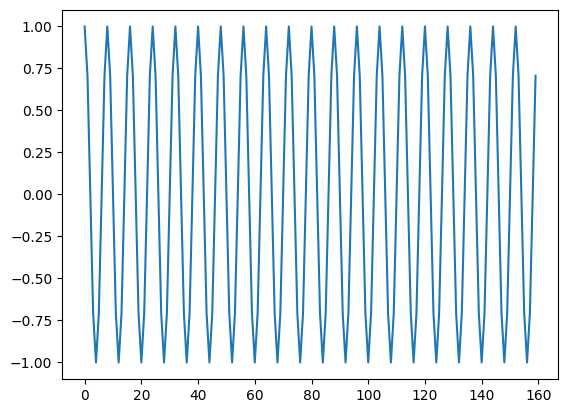

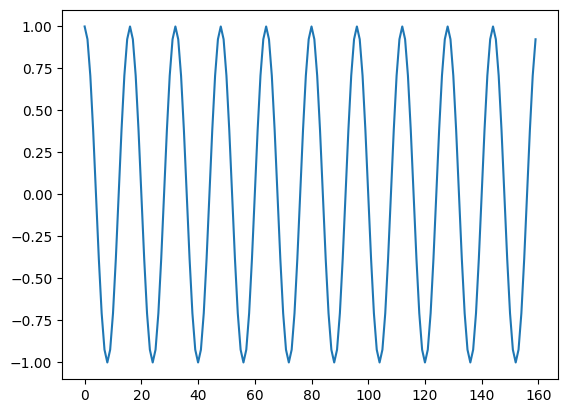

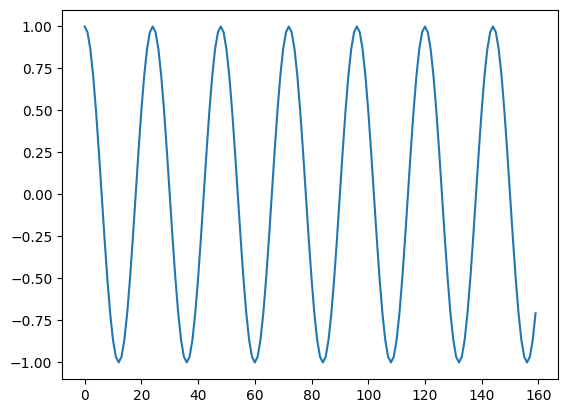

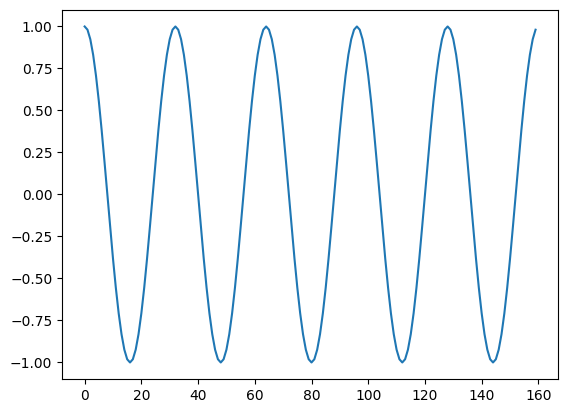

In [12]:
import matplotlib.pyplot as plt
mean_freq_coeff = 0.25
num_labels = 4

freqs = np.pi * mean_freq_coeff / np.arange(1, 1 + num_labels)
prior_means = np.tile(np.arange(1 * 80 * 2).reshape([1, -1]),
                    [num_labels, 1])
prior_means = np.cos(prior_means * freqs[:, None])
# prior_means = prior_means.reshape([num_labels, 3, 32, 32])
# prior_means = prior_means.reshape([num_labels, -1])

for counter in range(num_labels):
    plt.plot(prior_means[counter])
    plt.show()

In [1]:
import torch
B, A, T, D = 2, 3, 4, 5
x = torch.randn(B, A, T, D)
y = torch.randn(B)

# Unsqueeze y so that it has shape [B, 1, 1, 1]
y_expanded = y.view(B, 1, 1, 1)  # or y.unsqueeze(1).unsqueeze(2).unsqueeze(3)

# Now you can multiply:
result = x * y_expanded

In [2]:
import torch
import logging
import pickle
import glob
import random
import numpy as np
from torch.utils.data import Dataset
from torch.nn import functional as F
from typing import Union
from functools import partial


def set_seed(CUR_SEED):
    random.seed(CUR_SEED)
    np.random.seed(CUR_SEED)
    torch.manual_seed(CUR_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def alpha_bar_cosine(time_step, s = 0.0, e = 1.0, tau=1.0, clip_min = 1e-9, **kwargs):
    v_start = np.cos((s + 0.008) / 1.008 * np.pi / 2) ** (2*tau)
    v_end = np.cos((e + 0.008) / 1.008 * np.pi / 2) ** (2*tau)
    v = np.cos((time_step * (e-s)+s + 0.008) / 1.008 * np.pi / 2) ** (2*tau)
    return np.clip((v_end - v) / (v_end - v_start), clip_min, 1)
    # return np.cos((time_step + 0.008) / 1.008 * np.pi / 2) ** 2
    
def alpha_bar_log(time_step, tau = 2.5, clip_min = 1e-9, **kwargs):
    # ! Hard code to shift the schedule 
    # delta = 10**-tau
    # return np.clip(np.log(time_step+delta)/np.log(delta), clip_min, 1)
    
    delta = 10**-tau
    v_start = np.log(delta)
    v_end = np.log(1+delta)
    v = np.log(time_step+delta)
    return np.clip((v_end - v) / (v_end - v_start), clip_min, 1)

def alpha_bar_linear(time_step, clip_min = 1e-9, **kwargs):
    return np.clip((1-time_step), clip_min, 1.)

def alpha_bar_sigmoid(time_step, s = -3, e = 3, tau=1, clip_min = 1e-9, **kwargs):
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    v_start = sigmoid(s/tau)
    v_end = sigmoid(e/tau)
    v = sigmoid((time_step*(e-s)+s)/tau)
    return np.clip((v_end - v) / (v_end - v_start), clip_min, 1)

def get_beta_schedule(variant, num_diffusion_timesteps, clip_min = 1e-9, max_beta=0.999, scale = 1.0, **kwargs):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function, which defines the cumulative product of
    (1-beta) over time from t = [0,1].

    Contains a function alpha_bar that takes an argument t and transforms it to the cumulative product of (1-beta) up
    to that part of the diffusion process.
    """

    if variant == 'cosine':
        alpha_bar = partial(alpha_bar_cosine, clip_min = clip_min, **kwargs)
    elif variant == 'log':
        alpha_bar = partial(alpha_bar_log, clip_min = clip_min, **kwargs)
    elif variant == 'sigmoid':
        alpha_bar = partial(alpha_bar_sigmoid, clip_min = clip_min, **kwargs)
    elif variant == 'linear':
        alpha_bar = partial(alpha_bar_linear, clip_min = clip_min, **kwargs)

    betas = [(1 - alpha_bar(time_step = 0)*scale)]
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(time_step = t2) / alpha_bar(time_step = t1), max_beta))
    # betas[0] = betas[0]*(1-scale)
    return torch.tensor(betas, dtype=torch.float32)

def get_beta_schedule_cifar(beta_schedule, beta_start=1e-4, beta_end=0.02, timesteps=1000, dtype=torch.float64, cosine_s = 8e-3,):
    # print(beta_schedule)
    if beta_schedule == 'quad':
        betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, timesteps, dtype=dtype) ** 2
    elif beta_schedule == 'linear':
        betas = torch.linspace(beta_start, beta_end, timesteps, dtype=dtype)
    elif beta_schedule == "cosine":
        timesteps = (
            torch.arange(timesteps + 1, dtype=torch.float64) / timesteps + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
        # print (betas)
    elif beta_schedule == 'warmup10':
        betas = _warmup_beta(beta_start, beta_end, timesteps, 0.1, dtype=dtype)
    elif beta_schedule == 'warmup50':
        betas = _warmup_beta(beta_start, beta_end, timesteps, 0.5, dtype=dtype)
    elif beta_schedule == 'const':
        betas = beta_end * torch.ones(timesteps, dtype=dtype)
    elif beta_schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / torch.linspace(timesteps, 1, timesteps, dtype=dtype)
    else:
        raise NotImplementedError(beta_schedule)
    # assert betas.shape == (timesteps, )
    return betas

In [4]:
a = get_beta_schedule("cosine", 1000)

In [5]:
b = get_beta_schedule_cifar("linear", timesteps=1000)

In [6]:
a.shape

torch.Size([1001])

In [7]:
b.shape

torch.Size([1000])